# Modele de CNN multihead  

In [1]:
# Package 
import pandas as pd
import numpy as np
from numpy import array
from numpy import hstack
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [2]:
pretraitement = pd.read_csv(r'C:\Users\louis\OneDrive\Documents\ENSAE\2A\Safran\pretraitement.csv')
pretraitement= pretraitement.drop('Unnamed: 0', axis= 1)
pretraitement.index = pretraitement['date']
del pretraitement['date']

In [3]:
X_Y_treat = pd.read_csv(r'C:\Users\louis\OneDrive\Documents\ENSAE\2A\Safran\X_Y_treat.csv')
X_Y_treat=X_Y_treat.drop('Unnamed: 0', axis = 1)
# On retire les valeurs extrémes de la pente de la norme EGT : 
X_Y_treat = X_Y_treat.drop(X_Y_treat[X_Y_treat.Interpolate_egt_slope<-4].index)
X_Y_treat = X_Y_treat.drop(X_Y_treat[X_Y_treat.Interpolate_egt_slope> 8].index)
X_Y_treat

,engine_series_Engine_series_1,engine_series_Engine_series_2,engine_series_Engine_series_3,engine_series_Engine_series_4,engine_series_Engine_series_5,engine_series_Engine_series_6,engine_series_Engine_series_7,config_A_Config_A_1,config_A_Config_A_2,config_A_Config_A_3,...,Interpolate_var_env_4_3.0,cycles_counter,Interpolate_var_mot_1,Interpolate_flight_leg_hours,Interpolate_var_env_1,Interpolate_var_env_2,Interpolate_var_env_3,Interpolate_var_env_5,id_int,Interpolate_egt_slope
0,1,0,0,0,0,0,0,0,1,0,...,0,8.230577,-0.426772,1.634167,-0.549037,-0.190762,-0.498373,-0.453776,1823,-0.027761
1,1,0,0,0,0,0,0,0,1,0,...,0,8.236156,-0.215641,1.234722,-0.601578,-0.215862,-0.638738,-0.408876,1823,-0.027761
2,1,0,0,0,0,0,0,0,1,0,...,0,8.220134,-0.754736,1.853611,-0.564630,-0.190762,-0.814039,1.154726,1823,-0.027761
3,1,0,0,0,0,0,0,0,1,0,...,0,8.223627,-0.656084,2.323333,-0.451994,-0.215862,-0.461992,0.345676,1823,-0.027761
4,1,0,0,0,0,0,0,0,1,0,...,0,8.234565,-0.272599,1.966389,-0.583961,-0.349390,0.869515,-0.855902,1823,-0.027761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661595,1,0,0,0,0,0,0,1,0,0,...,0,4.304065,0.704721,0.759722,-0.483550,0.193871,0.238183,1.154726,8438,-0.029193
661596,1,0,0,0,0,0,0,1,0,0,...,0,6.432940,0.806313,0.763611,-0.203205,0.197381,-0.182706,0.099146,8438,-0.029193
661597,1,0,0,0,0,0,0,1,0,0,...,0,7.040536,-0.174969,0.928056,4.248051,-0.229253,-1.971483,0.802866,8438,-0.029193
661598,1,0,0,0,0,0,0,1,0,0,...,0,5.874931,0.630343,1.248333,-0.389441,-0.109125,0.764293,-1.308293,8438,-0.029193


## Etude 

In [4]:
X_Y_treat.describe()

,engine_series_Engine_series_1,engine_series_Engine_series_2,engine_series_Engine_series_3,engine_series_Engine_series_4,engine_series_Engine_series_5,engine_series_Engine_series_6,engine_series_Engine_series_7,config_A_Config_A_1,config_A_Config_A_2,config_A_Config_A_3,...,Interpolate_var_env_4_3.0,cycles_counter,Interpolate_var_mot_1,Interpolate_flight_leg_hours,Interpolate_var_env_1,Interpolate_var_env_2,Interpolate_var_env_3,Interpolate_var_env_5,id_int,Interpolate_egt_slope
count,661200.000000,661200.000000,661200.000000,661200.000000,661200.000000,661200.000000,661200.000000,661200.000000,661200.000000,661200.000000,...,661200.000000,661200.000000,661200.000000,661200.000000,661200.000000,661200.000000,661200.000000,661200.000000,661200.000000,661200.000000
mean,0.891010,0.001378,0.071766,0.031459,0.002874,0.000907,0.000605,0.577288,0.391995,0.030563,...,0.002332,7.002443,0.003168,2.127982,0.021996,-0.012016,-0.015122,0.036765,5131.381125,-0.032698
std,0.311627,0.037093,0.258101,0.174556,0.053529,0.030110,0.024589,0.493991,0.488196,0.172130,...,0.048236,1.061555,0.937771,1.184700,0.992821,0.970250,1.022693,0.972436,1909.104479,0.097910
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-3.178409,-0.506389,-0.609974,-0.371714,-5.233369,-3.570250,1823.000000,-3.743205
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,6.453625,-0.501034,1.200556,-0.530054,-0.357955,-0.708817,-0.504042,3478.750000,-0.042352
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,7.229114,0.211951,1.890833,-0.329785,-0.316066,0.238182,0.199678,5131.500000,-0.025691
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,7.780303,0.692263,2.755000,0.155352,-0.135369,0.764293,0.752600,6784.250000,-0.014029
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,8.945202,2.953344,14.239720,54.145700,21.163010,3.710513,21.763660,8438.000000,3.313791


In [5]:
X_Y_treat.Interpolate_egt_slope.describe()

count    661200.000000
mean         -0.032698
std           0.097910
min          -3.743205
25%          -0.042352
50%          -0.025691
75%          -0.014029
max           3.313791
Name: Interpolate_egt_slope, dtype: float64

<AxesSubplot:title={'center':'Représentation de la marge EGT pour un échantillon ( 100 vols)'}, xlabel='date'>

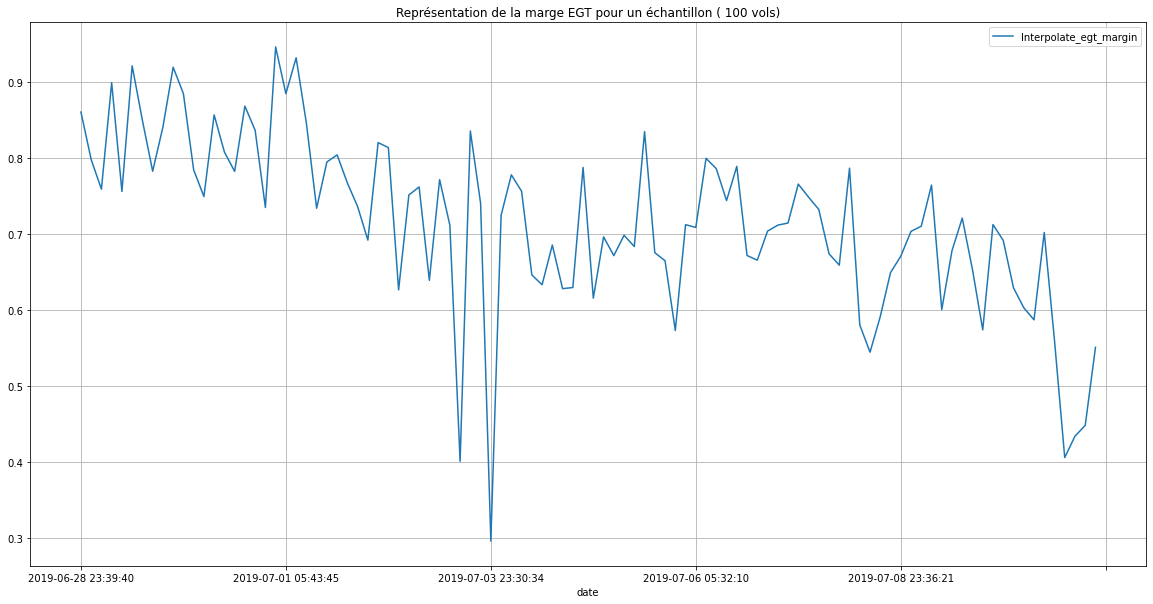

In [6]:
pretraitement[pretraitement.engine_serial_number == 'ESN_7'].head(100).plot( y=['Interpolate_egt_margin'], figsize=(20,10), grid=True, title = 'Représentation de la marge EGT pour un échantillon ( 100 vols)')

In [7]:
pretraitement[pretraitement.Interpolate_egt_slope >1 ]

,engine_serial_number,engine_family,engine_series,cycles,cycles_counter,egt_margin,var_mot_1,flight_leg_hours,event_rank,egt_slope,...,Interpolate_flight_leg_hours,Interpolate_SV_rank,Interpolate_Config_B_rank,Interpolate_WW_rank,Interpolate_var_env_1,Interpolate_var_env_2,Interpolate_var_env_3,Interpolate_var_env_4,Interpolate_var_env_5,Interpolate_egt_slope
date,,,,,,,,,,,,,,,,,,,,,
2021-08-29 04:26:58,ESN_3,Engine_family_1,Engine_series_1,2939.819863,3173,-3.012850,-0.214769,1.545833,18,6.714120,...,1.545833,1.0,9.0,4.0,-0.543789,-0.348429,-2.602815,0.0,0.752600,6.714120
2021-08-29 12:37:18,ESN_3,Engine_family_1,Engine_series_1,2940.259229,3174,-2.807086,-1.114584,1.512778,18,6.714120,...,1.512778,1.0,10.0,4.0,-0.596666,-0.361244,-2.497593,0.0,0.300209,6.714120
2021-08-29 15:18:49,ESN_3,Engine_family_1,Engine_series_1,2940.403958,3175,-2.963642,0.637014,1.065833,18,6.714120,...,1.065833,1.0,10.0,4.0,-0.562807,-0.348429,-2.813260,0.0,1.104460,6.714120
2021-08-29 17:29:50,ESN_3,Engine_family_1,Engine_series_1,2940.521356,3176,-3.156967,0.580022,1.048333,18,6.714120,...,1.048333,1.0,10.0,4.0,-0.581427,-0.369373,-2.392371,0.0,0.300209,6.714120
2021-08-29 20:42:57,ESN_3,Engine_family_1,Engine_series_1,2940.697140,3177,NaN,NaN,2.160556,18,6.714120,...,2.160556,1.0,10.0,4.0,-0.599747,-0.348429,-2.076705,0.0,-0.705105,6.714120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-04 06:13:10,ESN_975,Engine_family_1,Engine_series_3,31.046980,37,0.183009,1.583424,2.436389,0,2.162239,...,2.436389,0.0,0.0,0.0,0.132120,-0.301878,-0.284809,0.0,0.899920,2.162239
2022-04-04 10:11:47,ESN_975,Engine_family_1,Engine_series_3,31.556920,39,-0.008645,-0.206725,3.032222,0,2.162239,...,3.032222,0.0,0.0,0.0,-0.424388,-0.245512,0.433318,0.0,-0.376347,2.162239
2022-04-04 18:03:21,ESN_975,Engine_family_1,Engine_series_3,32.539310,42,0.075203,1.072096,2.361111,0,2.162239,...,2.361111,0.0,0.0,0.0,-0.503168,-0.352742,-0.287928,0.0,-0.453776,2.162239


## Prétraitement des variables environnementales

A partir de ce dataframe, on souhaite décomposer les séries des variables environnementales en 3 séries :
- tendance 
- saisonnalité 
- bruit 

afin de les intégrer dans différentes branches du réseau de neurones. On retire la variable environnementale qui est catégorielle. 

Pour cela il faut trouver une période de temps ou une fréquence, sur laquelle les événements se répétent. 

Pour exemple, on affiche le graphique représentant la série var_env_1 pour deux moteurs (ESN_3 et ESN_45) sur leurs 200 premiers vols  : 

<AxesSubplot:xlabel='date'>

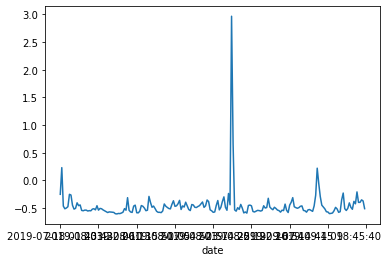

In [8]:
pretraitement[pretraitement.engine_serial_number=="ESN_3"].head(200)['Interpolate_var_env_1'].plot()

<AxesSubplot:xlabel='date'>

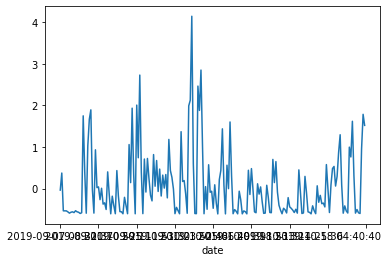

In [9]:
pretraitement[pretraitement.engine_serial_number=="ESN_45"].head(200)['Interpolate_var_env_1'].plot()

On remarque tout d'abord que les séries sont très différentes d'un moteur à l'autre. 

Analysons ces séries sur les intervalles de 100 vols choisis précedemment. 

In [10]:
# On décompose le dataframe complet en 6 616 échantillons de 100 vols :
dfs = np.array_split(X_Y_treat[['Interpolate_var_env_1','Interpolate_var_env_2', 'Interpolate_var_env_3', 'Interpolate_var_env_5', 'id_int']], 6616)

# Affichage d'un échantillon : 
dfs[50]

,Interpolate_var_env_1,Interpolate_var_env_2,Interpolate_var_env_3,Interpolate_var_env_5,id_int
5000,-0.549798,0.778065,1.395626,-1.207762,1873
5001,-0.521245,0.420856,0.974738,-0.353245,1873
5002,-0.560346,0.468015,1.344747,-1.601044,1873
5003,-0.609285,1.363350,1.185182,-2.062279,1873
5004,-0.592848,0.137042,0.737177,-1.045560,1873
...,...,...,...,...,...
5095,-0.376777,1.371828,1.290404,-1.358559,1873
5096,-0.544323,1.363350,-0.287928,0.400740,1873
5097,0.113395,0.280274,0.659071,0.249943,1873
5098,-0.604612,0.011144,0.553849,0.702335,1873


Comme précedemment, on compare les graphiques de différents échantillons : 

<AxesSubplot:>

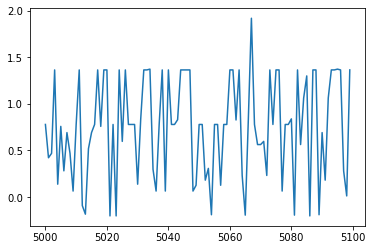

In [11]:
dfs[50].Interpolate_var_env_2.plot()

<AxesSubplot:>

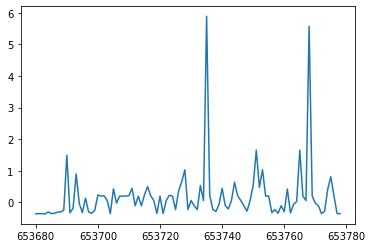

In [12]:
dfs[6536].Interpolate_var_env_2.plot()

Les graphiques sont très différents entre deux échantillons, pour une même variable environnementale. Il sera donc difficile de trouver une tendance et une saisonalité commune à tous les échantillons

Analysons les corrélations entre les différentes variables environnementales :

<AxesSubplot:>

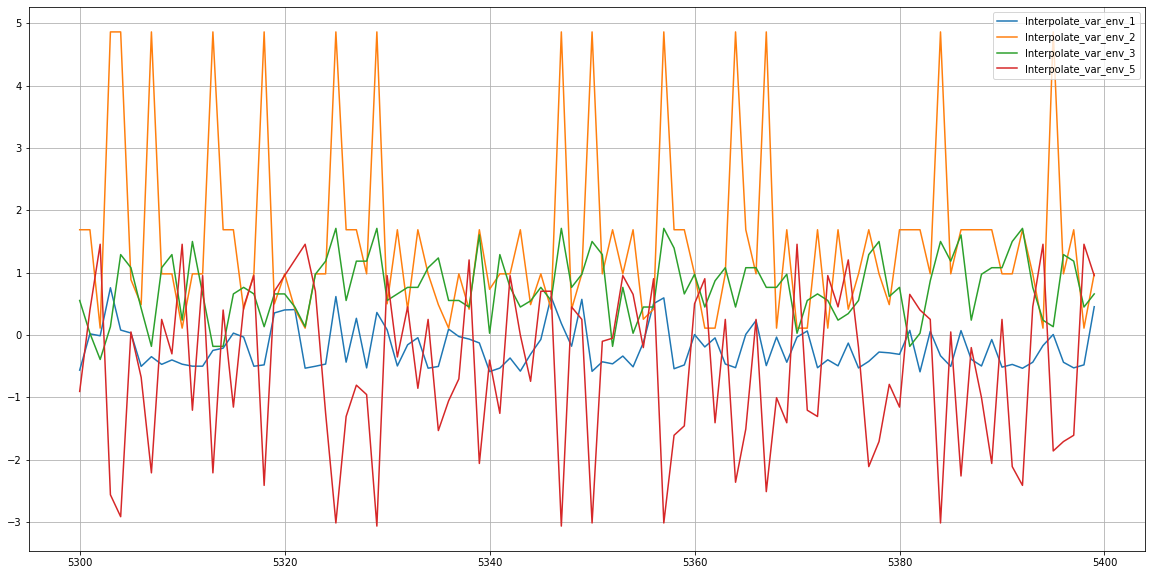

In [13]:
# Exemple pour l'échantillon 553 : 
dfs[53].plot( y=['Interpolate_var_env_1', 'Interpolate_var_env_2','Interpolate_var_env_3', 'Interpolate_var_env_5'], figsize=(20,10), grid=True)

Ce n'est pas impossible qu'il y ait une corrélation entre ces variables.

In [14]:
dfs[553].corr()

,Interpolate_var_env_1,Interpolate_var_env_2,Interpolate_var_env_3,Interpolate_var_env_5,id_int
Interpolate_var_env_1,1.000000,-0.151957,-0.023318,0.045225,NaN
Interpolate_var_env_2,-0.151957,1.000000,-0.309666,-0.416438,NaN
Interpolate_var_env_3,-0.023318,-0.309666,1.000000,-0.161656,NaN
Interpolate_var_env_5,0.045225,-0.416438,-0.161656,1.000000,NaN
id_int,NaN,NaN,NaN,NaN,NaN


Pour cet échantillon, il semblerait que les variables environnementales 3 et 5 soient négativement corrélées.

Analysons les corrélations de ces variables dans la base initiale 

In [15]:
pretraitement[['Interpolate_var_env_1', 'Interpolate_var_env_2','Interpolate_var_env_3', 'Interpolate_var_env_5']].corr()

,Interpolate_var_env_1,Interpolate_var_env_2,Interpolate_var_env_3,Interpolate_var_env_5
Interpolate_var_env_1,1.000000,0.021848,0.019692,0.110219
Interpolate_var_env_2,0.021848,1.000000,0.182493,-0.169041
Interpolate_var_env_3,0.019692,0.182493,1.000000,-0.311830
Interpolate_var_env_5,0.110219,-0.169041,-0.311830,1.000000


Les variables sont corrélées, pour certaines très faiblement.

Il est donc incertain que les séries des variables environnementales aient les mêmes propriétés de saisonnalité ou de tendance. Cependant, par soucis de temps et pour simplifier nos calculs nous ne chercherons pas à différencier les propriétés des différentes variables environnementales.

Nous cherchons à trouver la fréquence (unique pour toutes les variables environnementales) qui optimise les résultats du modèle 

In [16]:
def decompose_serie (serie, frequence ):
    '''
    Cette fonction permet de décomposer une série (composée de plusieurs échantillons) en fonction de la fréquence
    passée en paramètre. Elle renvoie la série décomposée en tendance, saisonnalité et bruit 
    
    Exemple :
    decompose_serie (dfs, 6 ) : décompose la série dfs, composée de 6 616, en 3 dataframes : la tendance, la saisonnalité,
    le bruit. 
    
    '''
    df_trend = pd.DataFrame(columns=['Var_1_trend','Var_2_trend','Var_3_trend' , 'Var_5_trend', 'id_int'])
    df_season = pd.DataFrame(columns=['Var_1_season','Var_2_season','Var_3_season', 'Var_5_season', 'id_int'])
    df_resid = pd.DataFrame(columns=['Var_1_resid','Var_2_resid','Var_3_resid' , 'Var_5_resid', 'id_int'])

    for i in range(len(serie)) :
        result_1 = seasonal_decompose(serie[i]['Interpolate_var_env_1'], model='additive', freq=frequence)
        result_2 = seasonal_decompose(serie[i]['Interpolate_var_env_2'], model='additive', freq=frequence)
        result_3 = seasonal_decompose(serie[i]['Interpolate_var_env_3'], model='additive', freq=frequence)
        result_5 = seasonal_decompose(serie[i]['Interpolate_var_env_5'], model='additive', freq=frequence)

        df_trend_i= pd.DataFrame({'Var_1_trend': result_1.trend ,'Var_2_trend' : result_2.trend,'Var_3_trend':result_3.trend, 'Var_5_trend':result_5.trend, 'id_int': dfs[i].id_int})
        df_trend_i= df_trend_i.fillna(df_trend_i.ffill())
        df_trend_i= df_trend_i.fillna(df_trend_i.bfill())
        df_trend = pd.concat([df_trend,df_trend_i])

        df_season_i= pd.DataFrame({'Var_1_season': result_1.seasonal ,'Var_2_season' : result_2.seasonal,'Var_3_season':result_3.seasonal, 'Var_5_season':result_5.seasonal, 'id_int': dfs[i].id_int})
        df_season = pd.concat([df_season,df_season_i])

        df_resid_i= pd.DataFrame({'Var_1_resid': result_1.resid,'Var_2_resid' : result_2.resid,'Var_3_resid':result_3.resid, 'Var_5_resid':result_5.resid, 'id_int': dfs[i].id_int})
        df_resid_i= df_resid_i.fillna(df_resid_i.ffill())
        df_resid_i= df_resid_i.fillna(df_resid_i.bfill())
        df_resid = pd.concat([df_resid,df_resid_i])

        if i == int(len(serie)/4):
            print("25% du traitement effectué")
        if i == int(len(serie)/2):
            print("50% du traitement effectué")
        if i == int(len(serie) *(3/4)):
            print("75% du traitement effectué")
        if i == int(len(serie)-1):
            print("Terminé ! ")
    return df_trend, df_season, df_resid

In [17]:
# Temps de traitement autour de 5 minutes
df_trend, df_season, df_resid = decompose_serie (dfs, 15 )

C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  app.launch_new_instance()
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead


25% du traitement effectué
50% du traitement effectué
75% du traitement effectué
Terminé ! 


In [18]:
# On introduit le dataframe correspondant aux autres variables à prendre en compte
df_complement = X_Y_treat.drop(['Interpolate_var_env_1', 'Interpolate_var_env_2',
       'Interpolate_var_env_3', 'Interpolate_var_env_5','id_int'], axis=1)

On traite nos dataframes pour qu'ils puissent entrer dans le modèle. 

On souhaite couper ce dataframe en échantillons de taille 100, où à chaque échantillon correspond une valeur de pente pour la marge EGT. 

In [19]:
def split_sequences_X_Y(sequences, n_steps) : 
    '''
    Découpage d'un dataframe correspondant aux variables X et Y, en échantillons de taille n_steps
    '''
    X, y = list(), list()
    n_iteration = int(len(sequences)/n_steps)
    if len(sequences)%n_steps != 0 : 
        print("Attention, modulo différent de zero")
    for i in range(n_iteration): 
        seq_x, seq_y = sequences [i*n_steps :(i+1)*n_steps, :-1 ], sequences[i*n_steps ,-1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)    

In [20]:
X_complement, y = split_sequences_X_Y(df_complement.values, 100)

In [21]:
def split_sequences_X(sequences, n_steps) : 
    '''
    Découpage d'un dataframe correspondant aux variables X en échantillon de taille n_steps
    '''
    X= list()
    n_iteration = int(len(sequences)/n_steps)
    if len(sequences)%n_steps != 0 : 
        print("Attention, modulo différent de zero")
    for i in range(n_iteration): 
        seq_x = sequences [i*n_steps :(i+1)*n_steps,:-1]
        X.append(seq_x)
    return array(X)

In [22]:
X_trend, X_season, X_resid =  split_sequences_X(df_trend.values, 100), split_sequences_X(df_season.values, 100), split_sequences_X(df_resid.values, 100)

In [23]:
X_trend.shape

(6612, 100, 4)

In [24]:
from sklearn.model_selection import train_test_split

In [141]:
X_complement_train, X_complement_test, X_trend_train , X_trend_test, X_season_train, X_season_test, X_resid_train, X_resid_test, Y_train, Y_test = train_test_split(X_complement,X_trend,X_season,X_resid, y, test_size = 0.2, random_state = 42)

In [142]:
(Y_train.min(),Y_train.max() )

(-3.743205, 3.313791)

In [143]:
(Y_test.min(), Y_test.max() )

(-1.080096, 0.781562)

In [144]:
Y_test

array([-0.02790776, -0.03308498, -0.02025453, ..., -0.05779171,
       -0.02211792, -0.00459374])

## Le modèle 

In [146]:
# Importation des packages de deep learning 
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential 
from keras.layers.core import (Dense,Dropout, Flatten)
from keras.layers.convolutional import Conv1D,Conv2D, MaxPooling1D, SeparableConv2D
from keras.layers import  concatenate
from keras.layers import LeakyReLU
from keras.layers import PReLU
from keras.initializers import Constant

from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import Input
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [147]:
# Branche 1 : Variables caractéristiques 
visible1 = Input(shape=(100, 23))
cnn1 = Conv1D(filters=32, kernel_size=2, activation = 'relu')(visible1)
cnn1 = Conv1D(filters=64, kernel_size=2, activation = 'relu')(cnn1)
cnn1 = MaxPooling1D(pool_size=2)(cnn1)
cnn1 = Conv1D(filters=128, kernel_size=2, activation = 'relu')(cnn1)
cnn1 = MaxPooling1D(pool_size=2)(cnn1)
cnn1 = Dropout(0.25)(cnn1)
cnn1 = Flatten()(cnn1)

In [148]:
# Branche 2 : Tendance Variables environnementales 
visible2 = Input(shape=(100, 4)) 
cnn2 = Conv1D(filters=32, kernel_size=2, activation = 'relu')(visible2)
cnn2 = Conv1D(filters=64, kernel_size=2, activation = 'relu')(cnn2)
cnn2 = MaxPooling1D(pool_size=2)(cnn2)
cnn2 = Dropout(0.25)(cnn2)
cnn2 = Flatten()(cnn2)

In [149]:
# Branche 3 : Saisonnalité Variables environnementales 
visible3 = Input(shape=(100, 4))
cnn3 = Conv1D(filters=32, kernel_size=2, activation = 'relu')(visible3)
cnn3 = Conv1D(filters=64, kernel_size=2, activation = 'relu')(cnn3)
cnn3 = MaxPooling1D(pool_size=2)(cnn3)
cnn3 = Dropout(0.25)(cnn3)
cnn3 = Conv1D(filters=128, kernel_size=2, activation = 'relu')(cnn3)
cnn3 = MaxPooling1D(pool_size=2)(cnn3)
cnn3 = Dropout(0.25)(cnn3)
cnn3 = Flatten()(cnn3)

In [150]:
# Branche 4 : Bruit Variables environnementales 
visible4 = Input(shape=(100, 4))
cnn4 = Conv1D(filters=32, kernel_size=2, activation = 'relu')(visible4)
cnn4 = Conv1D(filters=64, kernel_size=2, activation = 'relu')(cnn4)
cnn4 = MaxPooling1D(pool_size=2)(cnn4)
cnn4 = Dropout(0.25)(cnn4)
cnn4 = Flatten()(cnn4)

In [151]:
# merge input models
merge = concatenate([cnn1, cnn2, cnn3, cnn4])
dense = Dense(400)(merge)

output = Dense(1, activation="linear")(dense)

In [152]:
model = Model(inputs=[visible1, visible2,visible3,visible4 ], outputs=output)

In [153]:
model.compile(optimizer='adam', loss='mse', metrics=[ 'mae'])

In [154]:
# La condition suivante permet d'arrêter l'entrainement si le modéle n'apprend pas pendant 5 périodes : 
earlystop = EarlyStopping(patience=5) 
callbacks = [earlystop]

In [155]:
X_trend_train=np.asarray(X_trend_train).astype(np.float32)
X_season_train =np.asarray(X_season_train).astype(np.float32)
X_resid_train =np.asarray(X_resid_train).astype(np.float32)
X_trend_test=np.asarray(X_trend_test).astype(np.float32)
X_season_test =np.asarray(X_season_test).astype(np.float32)
X_resid_test=np.asarray(X_resid_test).astype(np.float32)

In [156]:
history= model.fit([X_complement_train, X_trend_train, X_season_train, X_resid_train], Y_train, epochs=40, validation_split = 0.2, callbacks =callbacks)

Epoch 1/40
133/133 [==============================] - 9s 66ms/step - loss: 23.3580 - mae: 1.9240 - val_loss: 0.1374 - val_mae: 0.2553
Epoch 2/40
133/133 [==============================] - 8s 63ms/step - loss: 0.1578 - mae: 0.2608 - val_loss: 0.0691 - val_mae: 0.1659
Epoch 3/40
133/133 [==============================] - 8s 63ms/step - loss: 0.0853 - mae: 0.2032 - val_loss: 0.0493 - val_mae: 0.1231
Epoch 4/40
133/133 [==============================] - 8s 63ms/step - loss: 0.0582 - mae: 0.1753 - val_loss: 0.0524 - val_mae: 0.1378
Epoch 5/40
133/133 [==============================] - 8s 64ms/step - loss: 0.0427 - mae: 0.1501 - val_loss: 0.0405 - val_mae: 0.1044
Epoch 6/40
133/133 [==============================] - 8s 63ms/step - loss: 0.0389 - mae: 0.1394 - val_loss: 0.0385 - val_mae: 0.0924
Epoch 7/40
133/133 [==============================] - 8s 63ms/step - loss: 0.0355 - mae: 0.1312 - val_loss: 0.0351 - val_mae: 0.0855
Epoch 8/40
133/133 [==============================] - 8s 63ms/step -

In [157]:
test_loss = model.evaluate([X_complement_test, X_trend_test, X_season_test, X_resid_test], Y_test)

42/42 [==============================] - 0s 9ms/step - loss: 0.0100 - mae: 0.0656


In [41]:
test_loss = model.evaluate([X_complement_test, X_trend_test, X_season_test, X_resid_test], Y_test)

42/42 [==============================] - 0s 8ms/step - loss: 0.0077 - mae: 0.0638


In [42]:
test_loss = model.evaluate([X_complement_test, X_trend_test, X_season_test, X_resid_test], Y_test)

42/42 [==============================] - 0s 8ms/step - loss: 0.0077 - mae: 0.0638


In [43]:
Y_test

array([-0.03335741, -0.03370077, -0.03844139, ..., -0.00795508,
       -0.04581955, -0.02107106])

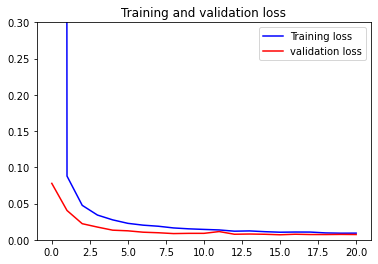

In [121]:
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
plt.title('Training and validation loss')
legend = plt.legend()

plt.ylim(0,0.3)
plt.show()

In [122]:
preds = model.predict([X_complement_test, X_trend_test, X_season_test, X_resid_test])

In [123]:
preds

array([[-0.15662871],
       [-0.04052958],
       [ 0.02082177],
       ...,
       [-0.04578574],
       [ 0.01571316],
       [-0.01262181]], dtype=float32)

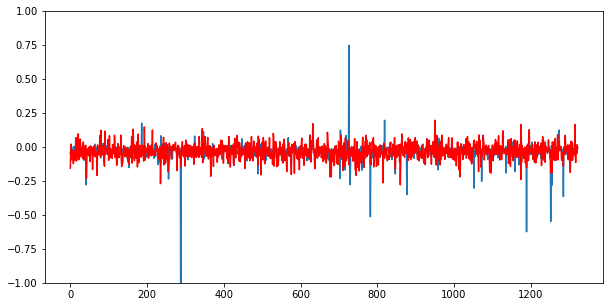

In [124]:
from matplotlib import pyplot
pyplot.figure(figsize=(10,5))
pyplot.plot(Y_test)
pyplot.plot(preds, 'r')
pyplot.ylim(-1,1)
pyplot.show()

C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


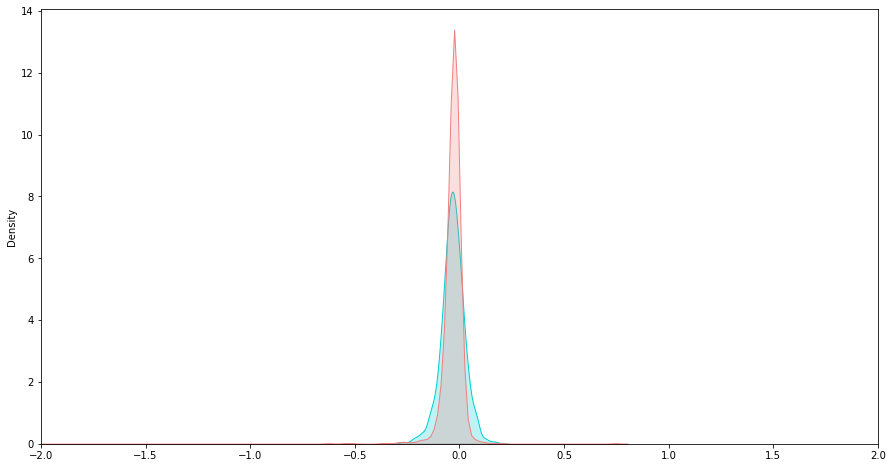

In [125]:
plt.figure(figsize=(15,8))
ax = sns.distplot(preds, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 1}, color="darkturquoise")
sns.distplot(Y_test, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 1}, color="lightcoral")
plt.xlim(-2,2)
plt.show()

In [57]:
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100, 4)]     0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 100, 23)]    0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 99, 32)       288         input_3[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 99, 32)       1504        input_1[0][0]                    
_______________________________________________________________________________________

## Choix des hyperparametres du modele : 

In [59]:
# Importation des packages
from hyperopt import hp # pour une première utilisation : pip install hyperopt
import kerastuner as kt # pour une première utilisation :  pip install keras-tuner
hp = kt.HyperParameters()

from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from kerastuner.tuners import Hyperband
from keras.models import load_model
from tensorflow.keras import metrics

In [60]:
keras.backend.clear_session()

In [126]:
# Création de la classe CNNHyperModel permettant de modifier les parametres souhaités

class HyperModel_CNN_multi_head (HyperModel):
    def __init__(self):
        self.input_shape_vars = (100, 23)
        self.input_shape_env = (100,4)

    def build(self, hp):

        visible1 = Input(shape=self.input_shape_vars)
        cnn1 = Conv1D(filters=hp.Choice("B1_num_filters_1", values=[16,32], default=32,), kernel_size=2, activation = 'relu')(visible1)
        cnn1 = Conv1D(filters=hp.Choice("B1_num_filters_2", values=[32,64], default=64,), kernel_size=2, activation = 'relu')(cnn1)
        cnn1 = MaxPooling1D(pool_size=2)(cnn1)
        cnn1 = Conv1D(filters=128, kernel_size=2, activation = 'relu')(cnn1)
        cnn1 = MaxPooling1D(pool_size=2)(cnn1)
        cnn1 = Dropout(rate=hp.Float("B1_dropout_1", min_value=0.0, max_value=0.5, default=0.25, step=0.05 ))(cnn1)
        cnn1 = Flatten()(cnn1)
        
        
        visible2 = Input(shape=self.input_shape_env ) 
        cnn2 = Conv1D(filters=hp.Choice("B2_num_filters_1", values=[16,32], default=32,), kernel_size=2, activation = 'relu')(visible2)
        cnn2 = Conv1D(filters=hp.Choice("B2_num_filters_2", values=[32,64], default=64,), kernel_size=2, activation = 'relu')(cnn2)
        cnn2 = MaxPooling1D(pool_size=2)(cnn2)
        cnn2 = Dropout(rate=hp.Float("B2_dropout_1", min_value=0.0, max_value=0.5, default=0.25, step=0.05,))(cnn2)
        cnn2 = Flatten()(cnn2)
        
        
        visible3 = Input(shape=self.input_shape_env )
        cnn3 = Conv1D(filters=hp.Choice("B3_num_filters_1", values=[16,32], default=32,), kernel_size=2, activation = 'relu')(visible3)
        cnn3 = Conv1D(filters=hp.Choice("B3_num_filters_2", values=[32,64], default=64,), kernel_size=2, activation = 'relu')(cnn3)
        cnn3 = MaxPooling1D(pool_size=2)(cnn3)
        cnn3 = Dropout(0.25)(cnn3)
        cnn3 = Conv1D(filters=hp.Choice("B3_num_filters_3", values=[64,128], default=128,), kernel_size=2, activation = 'relu')(cnn3)
        cnn3 = MaxPooling1D(pool_size=2)(cnn3)
        cnn3 = Dropout(rate=hp.Float("B3_dropout_1", min_value=0.0, max_value=0.5, default=0.25, step=0.05,))(cnn3)
        cnn3 = Flatten()(cnn3)
        
        
        visible4 = Input(shape=self.input_shape_env )
        cnn4 = Conv1D(filters=hp.Choice("B4_num_filters_1", values=[16,32], default=32,), kernel_size=2, activation = 'relu')(visible4)
        cnn4 = Conv1D(filters=hp.Choice("B4_num_filters_2", values=[32,64], default=64,), kernel_size=2, activation = 'relu')(cnn4)
        cnn4 = MaxPooling1D(pool_size=2)(cnn4)
        cnn4 = Dropout(rate=hp.Float("B4_dropout_1", min_value=0.0, max_value=0.5, default=0.25, step=0.05,))(cnn4)
        cnn4 = Flatten()(cnn4)
                         
                         
        merge = concatenate([cnn1, cnn2, cnn3, cnn4])
        dense = Dense(units=hp.Int("M_units_1", min_value=300, max_value=1000, step=32, default=128))(merge)
        dense = Dropout(rate=hp.Float("M_dropout_1", min_value=0.0, max_value=0.5, default=0.25, step=0.05,))(dense)
        dense = Dense(units=hp.Int("M_units_2", min_value=50, max_value=500, step=32, default=128))(merge)
        dense = Dense(50)(merge)
        output = Dense(1, activation="linear")(dense)
                         
                         
        model = Model(inputs=[visible1, visible2,visible3,visible4 ], outputs=output)
                         
        model.compile(optimizer=keras.optimizers.Adam(hp.Float("learning_rate",min_value=1e-4,max_value=1e-2,sampling="LOG",default=1e-3,)), loss='mse')

        return model
    
    
hypermodel = HyperModel_CNN_multi_head()

In [127]:
tuner= Hyperband(hypermodel, max_epochs= 40, objective = 'loss' , executions_per_trial=2, directory='hyperband', project_name='Usure_avions',overwrite = True)

In [69]:
# Récapitulatif des parametres à tester :
tuner.search_space_summary()

Search space summary
Default search space size: 17
B1_num_filters_1 (Choice)
{'default': 32, 'conditions': [], 'values': [16, 32], 'ordered': True}
B1_num_filters_2 (Choice)
{'default': 64, 'conditions': [], 'values': [32, 64], 'ordered': True}
B1_dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
B2_num_filters_1 (Choice)
{'default': 32, 'conditions': [], 'values': [16, 32], 'ordered': True}
B2_num_filters_2 (Choice)
{'default': 64, 'conditions': [], 'values': [32, 64], 'ordered': True}
B2_dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
B3_num_filters_1 (Choice)
{'default': 32, 'conditions': [], 'values': [16, 32], 'ordered': True}
B3_num_filters_2 (Choice)
{'default': 64, 'conditions': [], 'values': [32, 64], 'ordered': True}
B3_num_filters_3 (Choice)
{'default': 128, 'conditions': [], 'values': [64, 128], 'ordered': True}
B3_dropout_1 (Floa

In [128]:
tuner.search([X_complement_train, X_trend_train, X_season_train, X_resid_train], Y_train, epochs = 20, validation_split=0.2)

Trial 90 Complete [00h 02m 50s]
loss: 0.0018557709408923984

Best loss So Far: 0.0018557709408923984
Total elapsed time: 00h 58m 52s
INFO:tensorflow:Oracle triggered exit


In [129]:
tuner.search([X_complement_train, X_trend_train, X_season_train, X_resid_train], Y_train, epochs = 20, validation_split=0.2)


Search: Running Trial #91

Hyperparameter    |Value             |Best Value So Far 
B1_num_filters_1  |16                |32                
B1_num_filters_2  |64                |32                
B1_dropout_1      |0.05              |0.3               
B2_num_filters_1  |16                |16                
B2_num_filters_2  |32                |32                
B2_dropout_1      |0.2               |0.1               
B3_num_filters_1  |16                |32                
B3_num_filters_2  |32                |64                
B3_num_filters_3  |128               |128               
B3_dropout_1      |0.1               |0.15              
B4_num_filters_1  |32                |16                
B4_num_filters_2  |32                |32                
B4_dropout_1      |0.2               |0.05              
M_units_1         |780               |556               
M_dropout_1       |0                 |0.4               
M_units_2         |178               |402               
lea

KeyboardInterrupt: 

In [131]:
tuner.results_summary()

Results summary
Results in hyperband\Usure_avions
Showing 10 best trials
Objective(name='loss', direction='min')
Trial summary
Hyperparameters:
B1_num_filters_1: 32
B1_num_filters_2: 32
B1_dropout_1: 0.30000000000000004
B2_num_filters_1: 16
B2_num_filters_2: 32
B2_dropout_1: 0.1
B3_num_filters_1: 32
B3_num_filters_2: 64
B3_num_filters_3: 128
B3_dropout_1: 0.15000000000000002
B4_num_filters_1: 16
B4_num_filters_2: 32
B4_dropout_1: 0.05
M_units_1: 556
M_dropout_1: 0.4
M_units_2: 402
learning_rate: 0.0006183930099784303
tuner/epochs: 40
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.0018557709408923984
Trial summary
Hyperparameters:
B1_num_filters_1: 32
B1_num_filters_2: 64
B1_dropout_1: 0.45
B2_num_filters_1: 16
B2_num_filters_2: 64
B2_dropout_1: 0.30000000000000004
B3_num_filters_1: 32
B3_num_filters_2: 64
B3_num_filters_3: 128
B3_dropout_1: 0.1
B4_num_filters_1: 32
B4_num_filters_2: 64
B4_dropout_1: 0.1
M_units_1: 428
M_dropout_1: 0.45
M_units_2: 466
learning_rate: 0.0

In [135]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.evaluate([X_complement_test, X_trend_test, X_season_test, X_resid_test], Y_test)

42/42 [==============================] - 0s 4ms/step - loss: 0.0074


0.007410929072648287

In [72]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.evaluate([X_complement_test, X_trend_test, X_season_test, X_resid_test], Y_test)

42/42 [==============================] - 0s 3ms/step - loss: 0.0046


0.004585875663906336

In [128]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.evaluate([X_complement_test, X_trend_test, X_season_test, X_resid_test], Y_test)

42/42 [==============================] - 0s 3ms/step - loss: 0.0039


0.0038854735903441906

In [136]:
preds = best_model.predict([X_complement_test, X_trend_test, X_season_test, X_resid_test])

C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


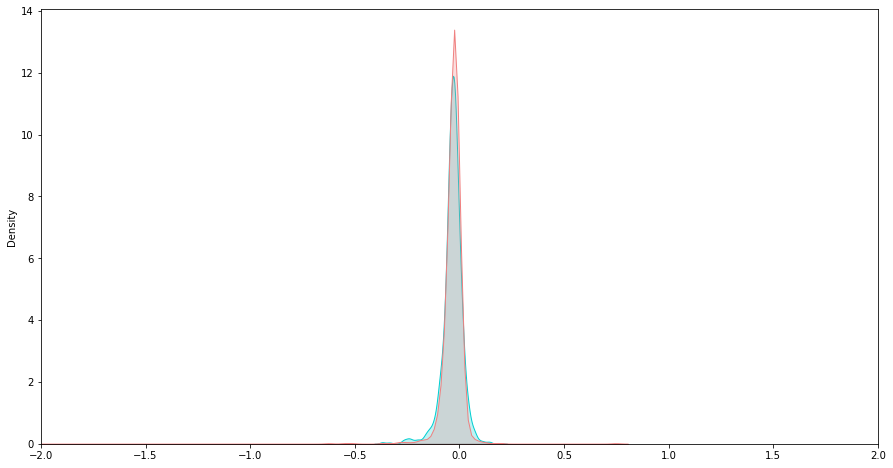

In [137]:
plt.figure(figsize=(15,8))
ax = sns.distplot(preds, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 1}, color="darkturquoise")
sns.distplot(Y_test, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 1}, color="lightcoral")
plt.xlim(-2,2)
plt.show()

In [138]:
history= best_model.fit([X_complement_train, X_trend_train, X_season_train, X_resid_train], Y_train, epochs=20, validation_split = 0.2, callbacks=callbacks)

Epoch 1/20
133/133 [==============================] - 2s 14ms/step - loss: 0.0019 - val_loss: 0.0051
Epoch 2/20
133/133 [==============================] - 2s 13ms/step - loss: 0.0033 - val_loss: 0.0055
Epoch 3/20
133/133 [==============================] - 2s 13ms/step - loss: 0.0018 - val_loss: 0.0053
Epoch 4/20
133/133 [==============================] - 2s 13ms/step - loss: 0.0017 - val_loss: 0.0055
Epoch 5/20
133/133 [==============================] - 2s 13ms/step - loss: 0.0022 - val_loss: 0.0053
Epoch 6/20
133/133 [==============================] - 2s 13ms/step - loss: 0.0032 - val_loss: 0.0052


In [139]:
test_loss = best_model.evaluate([X_complement_test, X_trend_test, X_season_test, X_resid_test], Y_test)


42/42 [==============================] - 0s 3ms/step - loss: 0.0075


In [147]:
def choix_frequence (serie, frequences) : 
    '''
    Fonction qui teste le modèle pour différentes fréquences passées en paramètre. 
    Attention, cette fonction met un certain temps à s'effectuer : proportionnel à la taille de la série et au nombre de 
    fréquences à tester.
    Elle renvoie un dataframe comprenant les différentes fréquences associées à la loss sur la base de test. 
    '''
    df_result_freq = pd.DataFrame(columns=['Frequence','Loss'])
    for frequence in frequences : 
        print("En cours de traitement de la fréquence : ", frequence)
        df_trend, df_season, df_resid = decompose_serie (serie, frequence)
        X_trend, X_season, X_resid =  split_sequences_X(df_trend.values, 100), split_sequences_X(df_season.values, 100), split_sequences_X(df_resid.values, 100)
        (X_complement_train, X_complement_test, X_trend_train , X_trend_test, X_season_train, X_season_test, X_resid_train, X_resid_test, Y_train, Y_test) = train_test_split(X_complement,X_trend,X_season,X_resid, y, test_size = 0.2, random_state=42)
        X_trend_train=np.asarray(X_trend_train).astype(np.float32)
        X_season_train =np.asarray(X_season_train).astype(np.float32)
        X_resid_train =np.asarray(X_resid_train).astype(np.float32)
        X_trend_test=np.asarray(X_trend_test).astype(np.float32)
        X_season_test =np.asarray(X_season_test).astype(np.float32)
        X_resid_test=np.asarray(X_resid_test).astype(np.float32)
        
        history= best_model.fit([X_complement_train, X_trend_train, X_season_train, X_resid_train], Y_train, epochs=20, validation_split = 0.2, callbacks=callbacks)
        test_loss = best_model.evaluate([X_complement_test, X_trend_test, X_season_test, X_resid_test], Y_test)
        df_result_freq_i = pd.DataFrame({'Frequence': [frequence] ,'Loss' : [test_loss]})
        df_result_freq = pd.concat([df_result_freq,df_result_freq_i])
    return df_result_freq

In [146]:
df_result_freq = choix_frequence (dfs, [1,2,3,4,5,10,12,15,20,25,30,35,40,45])

En cours de traitement de la fréquence :  1


C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  app.launch_new_instance()
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead


KeyboardInterrupt: 

In [158]:
decompose_serie (dfs, 49)

C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  app.launch_new_instance()
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead


25% du traitement effectué
50% du traitement effectué
75% du traitement effectué
Terminé ! 


(        Var_1_trend  Var_2_trend  Var_3_trend  Var_5_trend id_int
 0         -0.511628    -0.274130    -0.348868     0.183746   1823
 1         -0.511628    -0.274130    -0.348868     0.183746   1823
 2         -0.511628    -0.274130    -0.348868     0.183746   1823
 3         -0.511628    -0.274130    -0.348868     0.183746   1823
 4         -0.511628    -0.274130    -0.348868     0.183746   1823
 ...             ...          ...          ...          ...    ...
 661595    -0.109935     0.167342    -0.228079    -0.319362   8438
 661596    -0.109935     0.167342    -0.228079    -0.319362   8438
 661597    -0.109935     0.167342    -0.228079    -0.319362   8438
 661598    -0.109935     0.167342    -0.228079    -0.319362   8438
 661599    -0.109935     0.167342    -0.228079    -0.319362   8438
 
 [661200 rows x 5 columns],
         Var_1_season  Var_2_season  Var_3_season  Var_5_season id_int
 0           0.045935     -0.055076      0.119615      0.247277   1823
 1           0.004860   

In [157]:
df_result_freq

,Frequence,Loss
0,1,0.011692
0,5,0.003085
0,10,0.015555
0,15,0.011198
0,20,0.020276
0,25,0.017868
0,30,0.016033
0,35,0.003710
0,40,0.001802
0,45,0.021620


In [ ]:
X_complement.shape[2]
X_complement=np.asarray(X_complement).astype(np.float32)

In [266]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='tanh', input_shape=(100, 28)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=2, activation='tanh', input_shape=(100, 28)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation="linear"))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [267]:
history = model.fit(X_complement, Y_train, epochs=10, validation_split = 0.2)

Epoch 1/10
166/166 [==============================] - ETA: 0s - loss: 1.2455

ValueError: Data cardinality is ambiguous:
  x sizes: 1324
  y sizes: 0
Please provide data which shares the same first dimension.

In [268]:
X_complement_train, X_complement_test, X_trend_train , X_trend_test, X_season_train, X_season_test, X_resid_train, X_resid_test, Y_train, Y_test = train_test_split(X_complement,X_trend,X_season,X_resid, y, test_size = 0.2)

In [269]:
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(100,4)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='linear'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [270]:
X_trend_train=np.asarray(X_trend_train).astype(np.float32)

In [271]:
history = model.fit(X_trend_train, Y_train, epochs=10, validation_split = 0.2)

Epoch 1/10
133/133 [==============================] - 1s 7ms/step - loss: 0.1584 - val_loss: 0.0130
Epoch 2/10
133/133 [==============================] - 0s 4ms/step - loss: 0.0642 - val_loss: 0.0103
Epoch 3/10
133/133 [==============================] - 0s 3ms/step - loss: 0.0581 - val_loss: 0.0140
Epoch 4/10
133/133 [==============================] - 0s 3ms/step - loss: 0.0602 - val_loss: 0.0559
Epoch 5/10
133/133 [==============================] - 0s 3ms/step - loss: 0.0644 - val_loss: 0.0058
Epoch 6/10
133/133 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0061
Epoch 7/10
133/133 [==============================] - 0s 3ms/step - loss: 0.0521 - val_loss: 0.0076
Epoch 8/10
133/133 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0048
Epoch 9/10
133/133 [==============================] - 0s 3ms/step - loss: 0.0512 - val_loss: 0.0046
Epoch 10/10
133/133 [==============================] - 0s 3ms/step - loss: 0.0497 - val_loss: 0.0057

In [272]:
x_input = X_complement_train[1]
x_input = x_input.reshape((1, 100, 28))

In [273]:
x_input

array([[[-1.0000000e+00, -1.0000000e+00,  1.0000000e+00, ...,
          5.5555556e-02,  0.0000000e+00,  3.7070000e+03],
        [-1.0000000e+00, -1.0000000e+00,  1.0000000e+00, ...,
          5.5555556e-02,  0.0000000e+00,  3.7070000e+03],
        [-1.0000000e+00, -1.0000000e+00,  1.0000000e+00, ...,
          5.5555556e-02,  0.0000000e+00,  3.7070000e+03],
        ...,
        [-1.0000000e+00, -1.0000000e+00,  1.0000000e+00, ...,
          5.5555556e-02,  0.0000000e+00,  3.7070000e+03],
        [-1.0000000e+00, -1.0000000e+00,  1.0000000e+00, ...,
          5.5555556e-02,  0.0000000e+00,  3.7070000e+03],
        [-1.0000000e+00, -1.0000000e+00,  1.0000000e+00, ...,
          5.5555556e-02,  0.0000000e+00,  3.7070000e+03]]], dtype=float32)

In [274]:
model.predict(x_input)

ValueError: in user code:

    C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer sequential_5 is incompatible with the layer: expected axis -1 of input shape to have value 4 but received input with shape [None, 100, 28]


In [275]:
Y_train[0]

-0.02995394

In [94]:
x_input = X_train[0:3]

In [95]:
x_input
x_input = x_input.reshape((3, 100, 15))

In [96]:
model.predict(x_input)

array([[ 0.30618152],
       [-0.5657972 ],
       [ 0.09630451]], dtype=float32)

In [97]:
model.predict(X_train[0:3])

array([[ 0.30618152],
       [-0.5657972 ],
       [ 0.09630451]], dtype=float32)